# MIT-BIH Arrhythmia Classification using SVM
This notebook demonstrates how to classify arrhythmia signals using Support Vector Machines (SVM).

In [1]:
# Import  libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import learning_curve

from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

from sklearn.decomposition import PCA


pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
%autosave 5

Autosaving every 5 seconds


In [2]:
# Load the MIT-BIH Arrhythmia Dataset
csv_file_path = r'D:\Documents\master\mldm\m1\semester-2\ml-fundamentals\project-combined\MIT-BIH Arrhythmia Database.csv'
df = pd.read_csv(csv_file_path)
df = df.drop(columns=['record'])
# remove records since they are not needed for prediction
df.head()

,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,0_qt_interval,0_st_interval,0_qrs_morph0,0_qrs_morph1,0_qrs_morph2,0_qrs_morph3,0_qrs_morph4,1_pre-RR,1_post-RR,1_pPeak,1_tPeak,1_rPeak,1_sPeak,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,N,76,313.0,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,18,66,7,-0.026824,-0.001236,0.016659,0.143241,0.996287,76,313.0,0.038310,0.025784,0.025930,0.025271,0.025930,2,18,22,2,0.025930,0.025930,0.025930,0.025436,0.025436
1,N,313,315.0,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,4,33,8,-0.059710,0.104030,0.691891,0.805549,0.084069,313,315.0,0.014264,0.045458,0.032573,-0.104503,-0.042009,26,27,62,9,-0.042009,-0.029498,0.005012,0.030892,0.002986
2,N,315,321.0,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,3,32,7,-0.065686,0.051459,0.630419,0.890794,0.091258,315,321.0,0.021311,0.008246,0.009528,0.008230,0.009528,3,8,12,1,0.009528,0.009528,0.008786,0.008786,0.008368
3,N,321,336.0,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,4,33,7,-0.071750,0.059376,0.652814,0.948490,0.136602,321,336.0,-0.000665,-0.009725,-0.010203,-0.010203,-0.020536,6,9,16,1,-0.020536,-0.020257,-0.018965,-0.016968,-0.014555
4,N,336,344.0,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,4,16,1,-0.074639,-0.054516,0.052823,0.296038,0.649990,336,344.0,0.024559,0.016925,0.016053,-0.099918,0.016053,16,5,31,10,0.016053,0.006742,0.002782,-0.007798,-0.051155


Dataset Exploration

In [ ]:
# Display the shape of the DataFrame
df.shape

(100689, 33)

In [ ]:
# Display the data types of each column in the DataFrame
df.dtypes

type               object
0_pre-RR            int64
0_post-RR         float64
0_pPeak           float64
0_tPeak           float64
0_rPeak           float64
0_sPeak           float64
0_qPeak           float64
0_qrs_interval      int64
0_pq_interval       int64
0_qt_interval       int64
0_st_interval       int64
0_qrs_morph0      float64
0_qrs_morph1      float64
0_qrs_morph2      float64
0_qrs_morph3      float64
0_qrs_morph4      float64
1_pre-RR            int64
1_post-RR         float64
1_pPeak           float64
1_tPeak           float64
1_rPeak           float64
1_sPeak           float64
1_qPeak           float64
1_qrs_interval      int64
1_pq_interval       int64
1_qt_interval       int64
1_st_interval       int64
1_qrs_morph0      float64
1_qrs_morph1      float64
1_qrs_morph2      float64
1_qrs_morph3      float64
1_qrs_morph4      float64
dtype: object

In [ ]:
# Check duplicates
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicated rows: {num_duplicates}")

# # If there are duplicates, you can remove them
# if num_duplicates > 0:
#     df = df.drop_duplicates()
#     print(f"Number of rows after removing duplicates: {df.shape[0]}")


Number of duplicated rows: 0


In [ ]:
# Display summary statistics of the DataFrame
df.describe()

,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,0_qt_interval,0_st_interval,0_qrs_morph0,0_qrs_morph1,0_qrs_morph2,0_qrs_morph3,0_qrs_morph4,1_pre-RR,1_post-RR,1_pPeak,1_tPeak,1_rPeak,1_sPeak,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
count,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000
mean,279.400947,278.588207,0.049772,0.372262,1.054485,-0.134376,-0.090466,28.326858,10.972817,59.776093,20.476417,-0.090466,0.006982,0.307773,0.551215,0.287992,279.400947,278.588207,0.030321,0.362252,-0.125448,-0.484347,-0.321359,11.212347,10.487163,36.112922,14.413412,-0.321359,-0.317836,-0.308809,-0.294919,-0.366798
std,81.915453,81.124963,0.168789,0.739879,0.617508,1.027590,0.189436,15.027789,9.468930,40.386054,29.668412,0.189436,0.260703,0.550010,0.628483,0.580650,81.915453,81.124963,0.134263,0.380767,0.598776,0.586377,0.447444,12.043096,8.799687,17.419760,9.118872,0.447444,0.456949,0.518043,0.593426,0.584913
min,11.000000,6.000000,-3.094391,-2.006422,-2.372835,-3.622550,-3.871359,0.000000,1.000000,5.000000,1.000000,-3.871359,-2.629032,-2.840410,-2.995204,-3.086096,11.000000,6.000000,-2.108257,-2.493494,-3.847312,-6.154873,-5.481982,0.000000,1.000000,5.000000,1.000000,-5.481982,-4.493784,-4.398122,-4.069726,-4.520327
25%,230.000000,230.000000,-0.054749,-0.249060,0.754047,-0.781784,-0.133274,18.000000,5.000000,33.000000,1.000000,-0.133274,-0.076125,-0.004178,0.154049,-0.024117,230.000000,230.000000,-0.015778,0.105671,-0.402745,-0.794018,-0.529435,3.000000,5.000000,25.000000,10.000000,-0.529435,-0.537288,-0.603469,-0.622269,-0.673902
50%,267.000000,266.000000,0.015865,0.240303,1.105142,-0.516340,-0.069539,27.000000,7.000000,46.000000,8.000000,-0.069539,-0.001659,0.116924,0.491977,0.271029,267.000000,266.000000,0.014349,0.290121,-0.081045,-0.369828,-0.111843,7.000000,8.000000,33.000000,12.000000,-0.111843,-0.115650,-0.151890,-0.196801,-0.262222
75%,324.000000,322.000000,0.125809,0.928176,1.424135,0.857247,-0.014636,38.000000,16.000000,75.000000,23.000000,-0.014636,0.099184,0.621546,0.943673,0.623918,324.000000,322.000000,0.059256,0.605447,0.101120,-0.161125,-0.028438,18.000000,13.000000,45.000000,17.000000,-0.028438,-0.016348,0.016088,0.040575,-0.052769
max,2114.000000,2114.000000,3.821118,4.118327,4.018918,4.018918,3.080710,170.000000,150.000000,334.000000,141.000000,3.080710,2.869694,3.331326,3.224798,2.632724,2114.000000,2114.000000,5.161310,7.002694,4.033554,3.317595,4.033554,260.000000,185.000000,412.000000,215.000000,4.033554,3.585718,2.691557,3.755566,2.869186


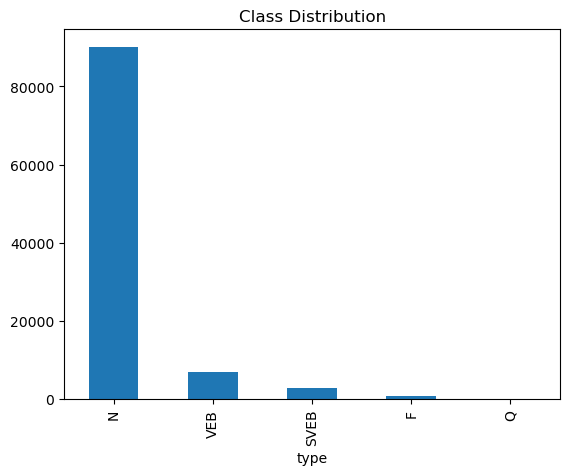

In [ ]:
# Plot the class distribution of the 'type' column
df['type'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

In [10]:
# Calculate skewness and kurtosis
df_drop = df.drop(columns=['type'])
skewness = df_drop.skew()
kurtosis = df_drop.kurtosis()
# Print short summary of skewness and kurtosis
print("Skewness and Kurtosis Summary:")
for col in df.select_dtypes(include=[np.number]).columns:
    print(f"{col}: Skewness = {skewness[col]:.2f}, Kurtosis = {kurtosis[col]:.2f}")

Skewness and Kurtosis Summary:
record: Skewness = -0.32, Kurtosis = -1.76
0_pre-RR: Skewness = 1.77, Kurtosis = 18.31
0_post-RR: Skewness = 1.80, Kurtosis = 18.96
0_pPeak: Skewness = 2.81, Kurtosis = 26.01
0_tPeak: Skewness = 0.57, Kurtosis = -0.42
0_rPeak: Skewness = -0.70, Kurtosis = 2.06
0_sPeak: Skewness = 0.52, Kurtosis = -0.69
0_qPeak: Skewness = -2.37, Kurtosis = 25.28
0_qrs_interval: Skewness = 0.94, Kurtosis = 2.79
0_pq_interval: Skewness = 2.00, Kurtosis = 7.59
0_qt_interval: Skewness = 1.27, Kurtosis = 1.08
0_st_interval: Skewness = 1.70, Kurtosis = 1.56
0_qrs_morph0: Skewness = -2.37, Kurtosis = 25.28
0_qrs_morph1: Skewness = -1.63, Kurtosis = 11.48
0_qrs_morph2: Skewness = 0.25, Kurtosis = 1.41
0_qrs_morph3: Skewness = -0.23, Kurtosis = 1.71
0_qrs_morph4: Skewness = -0.29, Kurtosis = 1.82
1_pre-RR: Skewness = 1.77, Kurtosis = 18.31
1_post-RR: Skewness = 1.80, Kurtosis = 18.96
1_pPeak: Skewness = 12.42, Kurtosis = 317.14
1_tPeak: Skewness = 1.01, Kurtosis = 4.14
1_rPeak: Sk

C:\Users\Admin\AppData\Local\Temp\ipykernel_14388\2853848925.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=skewness.index, y=skewness.values, palette='viridis')


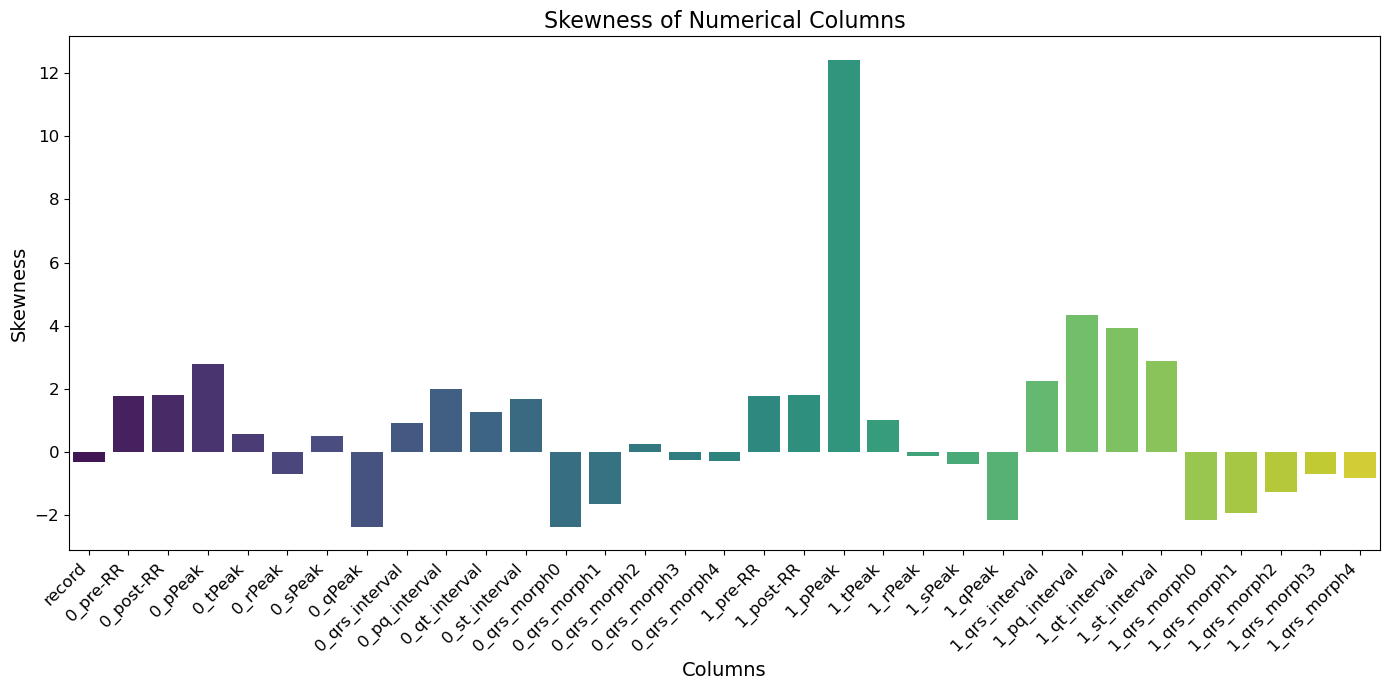

C:\Users\Admin\AppData\Local\Temp\ipykernel_14388\2853848925.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kurtosis.index, y=kurtosis.values, palette='viridis')


<Figure size 640x480 with 0 Axes>

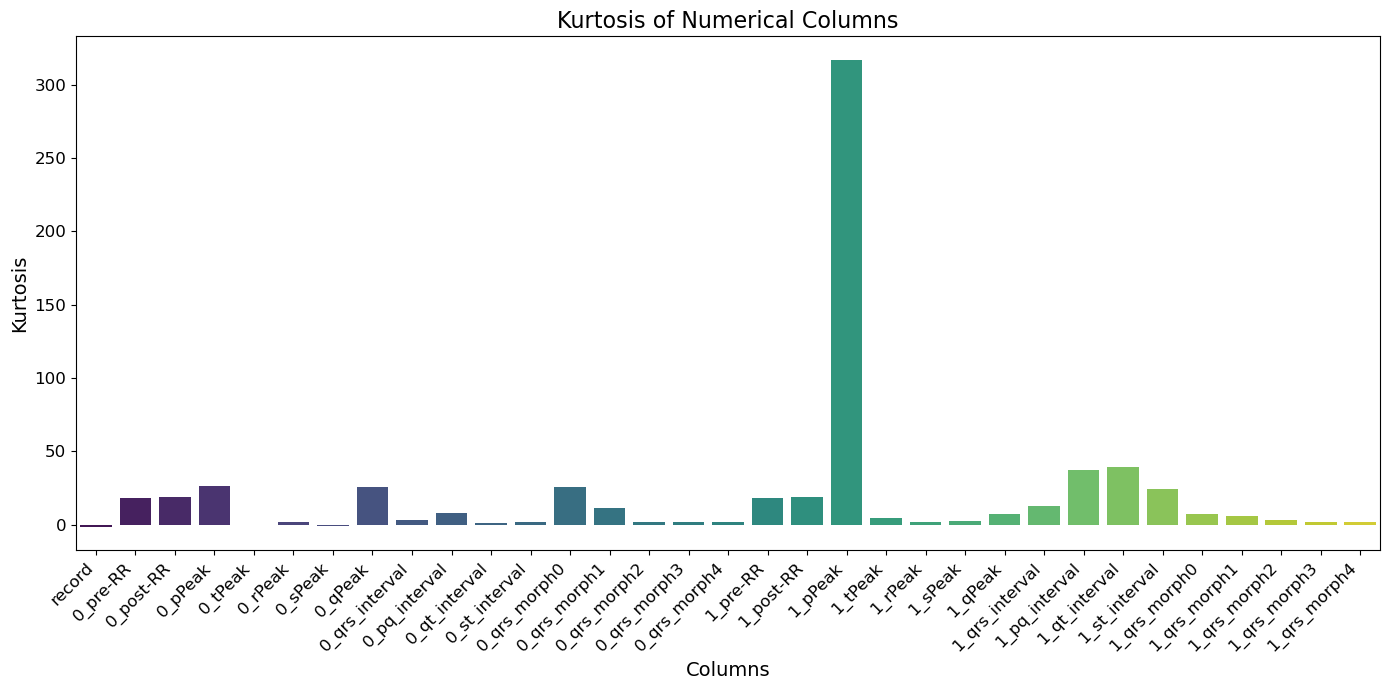

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize skewness
plt.figure(figsize=(14, 7))
sns.barplot(x=skewness.index, y=skewness.values, palette='viridis')
plt.title('Skewness of Numerical Columns', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Skewness', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig("Skewness.png")


# Visualize kurtosis
plt.figure(figsize=(14, 7))
sns.barplot(x=kurtosis.index, y=kurtosis.values, palette='viridis')
plt.title('Kurtosis of Numerical Columns', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Kurtosis', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig("Kurtosis.png")


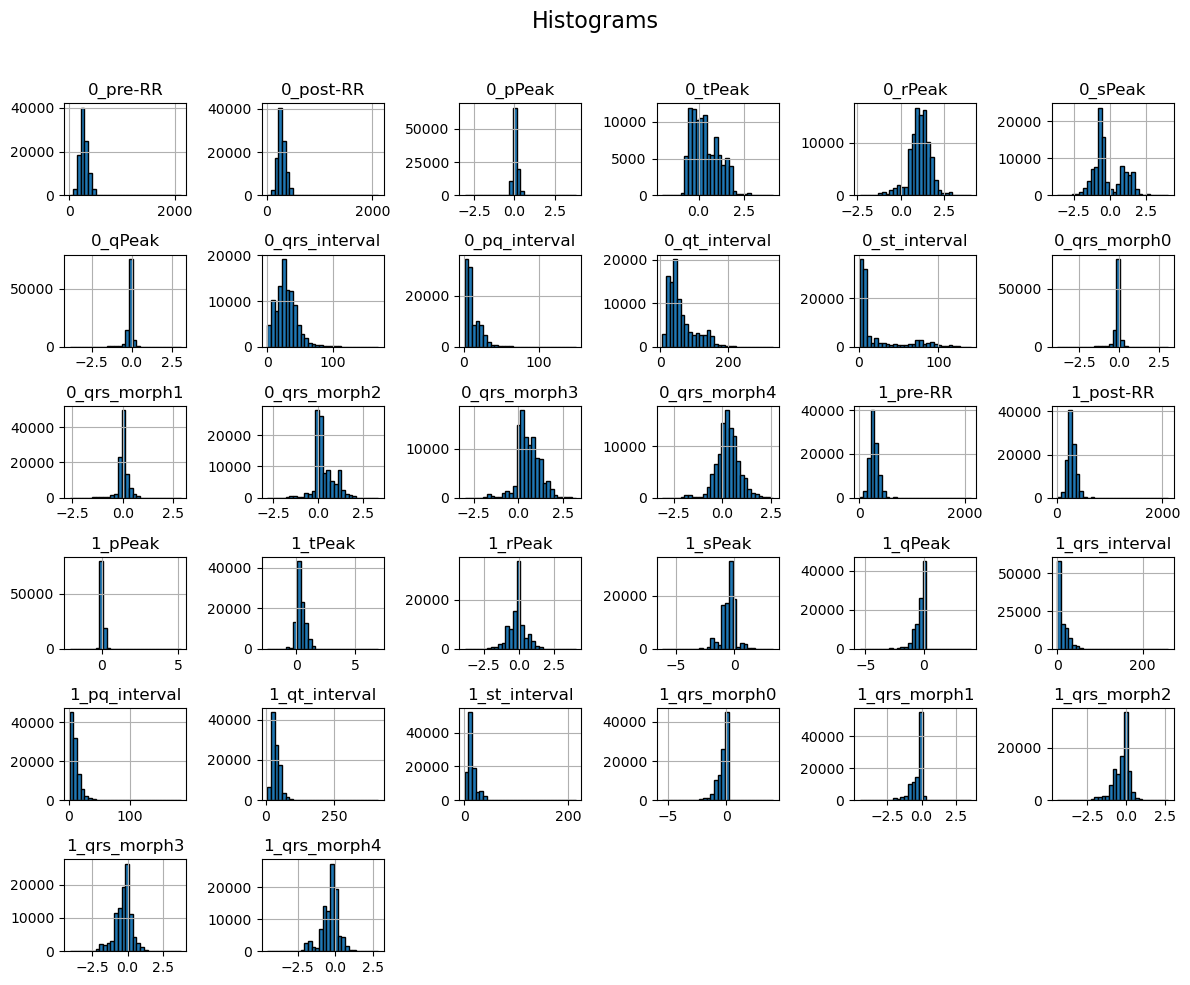

In [ ]:
# Check distribution of each feature (numerical columns)
df.drop(columns=['type']).hist(figsize=(12, 10), bins=30, edgecolor='black')

plt.suptitle('Histograms', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

for ax in plt.gcf().axes:
    ax.set_title(ax.get_title(), fontsize=12)
    ax.set_xlabel(ax.get_xlabel(), fontsize=10)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)

plt.show()

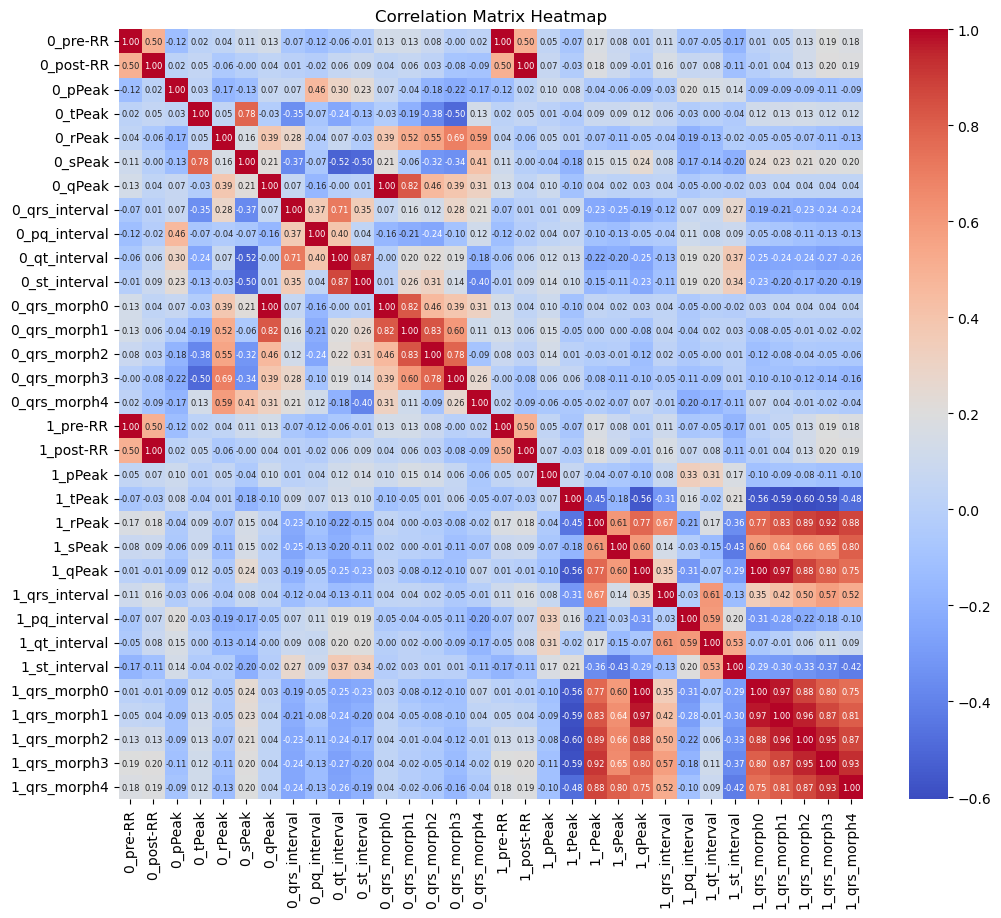

In [ ]:
# Check coeeficient of correlation between features
correlation_matrix = df.drop(columns=['type']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 6})
# sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

Data Preprocessing

In [43]:
# Handle missing values through imputation
# imputer = SimpleImputer(strategy='mean')
# df_imputed = pd.DataFrame(imputer.fit_transform(df.drop(columns=['type '])), columns=df.columns)
# No missing values in the dataset

C:\Users\Admin\AppData\Local\Temp\ipykernel_12876\2136266473.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_label.replace(['VEB', 'SVEB', 'F', 'Q'], 'arrhythmia', inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12876\2136266473.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_label.replace(['N'], 'normal', inplace=True)


type      
normal        90083
arrhythmia    10606
Name: count, dtype: int64


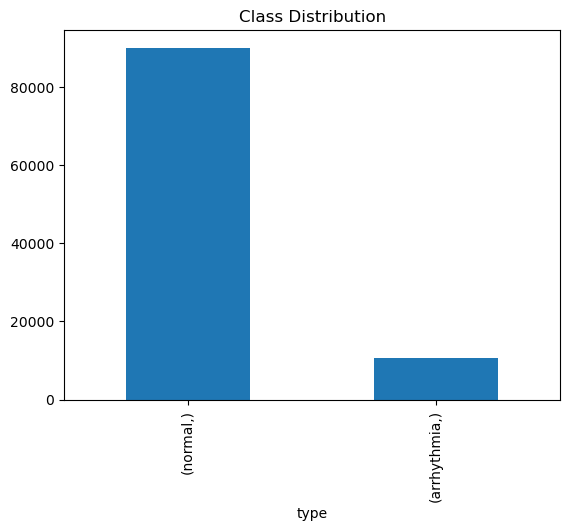

(100689, 32) (100689, 1)


In [50]:
# Extract features and labels
x_data = df.iloc[:, 1:]
y_label = df[['type']]

# Transform multi-class labels into binary-class (arrhythmia and normal)
y_label.replace(['VEB', 'SVEB', 'F', 'Q'], 'arrhythmia', inplace=True)
y_label.replace(['N'], 'normal', inplace=True)
print(y_label.value_counts())
y_label.value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

print(x_data.shape, y_label.shape)

In [51]:
#  Outlier removal using IQR method
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Remove outliers from the training data
x_data_no_outliers = remove_outliers(pd.DataFrame(x_data))
y_label_no_outliers = y_label.iloc[x_data_no_outliers.index]

print(x_data_no_outliers.shape, y_label_no_outliers.shape)


(54446, 32) (54446, 1)


In [52]:
# Normalize features for uniform scaling
scaler = StandardScaler()
x_data_scaled = pd.DataFrame(scaler.fit_transform(x_data_no_outliers), columns=x_data_no_outliers.columns)

# Remove redundant features using correlation analysis
# Remove highly correlated variables
correlation_matrix = x_data_scaled.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
redundant_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
x_data_reduced = x_data_scaled.drop(columns=redundant_features)
print(f"Removed features: {redundant_features}")
print(f"Remaining features: {x_data_reduced.columns.tolist()}")

# Eliminate low-variance features for efficiency
# Eliminate near-zero variance variables
selector = VarianceThreshold(threshold=0.01)
x_data_variance_filtered = pd.DataFrame(selector.fit_transform(x_data_reduced), columns=x_data_reduced.columns[selector.get_support()])
print(f"Remaining features: {x_data_variance_filtered.columns.tolist()}")
print(f"Removed features: {set(x_data_reduced.columns) - set(x_data_variance_filtered.columns)}")

# Use feature selection techniques (e.g., Mutual Information)
selector = SelectKBest(mutual_info_classif, k=10) # top features
x_data_selected = selector.fit_transform(x_data_variance_filtered, y_label_no_outliers)
selected_features = x_data_variance_filtered.columns[selector.get_support()]

print(x_data_selected.shape)

Removed features: ['0_qrs_morph0', '1_pre-RR', '1_post-RR', '1_qrs_morph0', '1_qrs_morph1', '1_qrs_morph3']
Remaining features: ['0_pre-RR', '0_post-RR', '0_pPeak', '0_tPeak', '0_rPeak', '0_sPeak', '0_qPeak', '0_qrs_interval', '0_pq_interval', '0_qt_interval', '0_st_interval', '0_qrs_morph1', '0_qrs_morph2', '0_qrs_morph3', '0_qrs_morph4', '1_pPeak', '1_tPeak', '1_rPeak', '1_sPeak', '1_qPeak', '1_qrs_interval', '1_pq_interval', '1_qt_interval', '1_st_interval', '1_qrs_morph2', '1_qrs_morph4']
Remaining features: ['0_pre-RR', '0_post-RR', '0_pPeak', '0_tPeak', '0_rPeak', '0_sPeak', '0_qPeak', '0_qrs_interval', '0_pq_interval', '0_qt_interval', '0_st_interval', '0_qrs_morph1', '0_qrs_morph2', '0_qrs_morph3', '0_qrs_morph4', '1_pPeak', '1_tPeak', '1_rPeak', '1_sPeak', '1_qPeak', '1_qrs_interval', '1_pq_interval', '1_qt_interval', '1_st_interval', '1_qrs_morph2', '1_qrs_morph4']
Removed features: set()


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(54446, 10)


In [53]:
# Convert categorical variables to numerical
label_encoder = LabelEncoder()
y_label_no_outliers = label_encoder.fit_transform(y_label_no_outliers.values.ravel())

In [55]:
print(x_data_selected.shape, y_label_no_outliers.shape)

(54446, 10) (54446,)


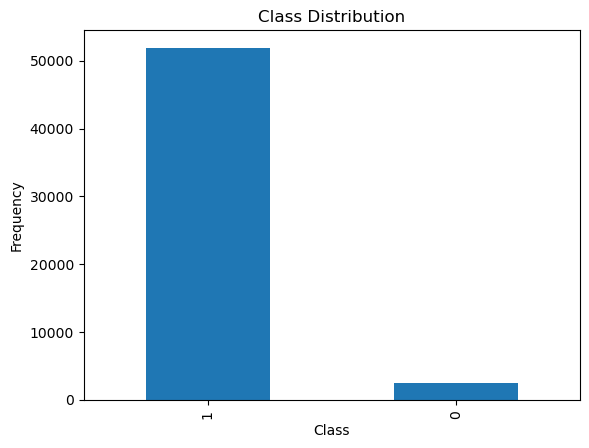

In [58]:
# Assuming y_label_no_outliers is a NumPy array
y_label_no_outliers_series = pd.Series(y_label_no_outliers)

# Plot class distribution
y_label_no_outliers_series.value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

type
1    51909
0    51909
Name: count, dtype: int64


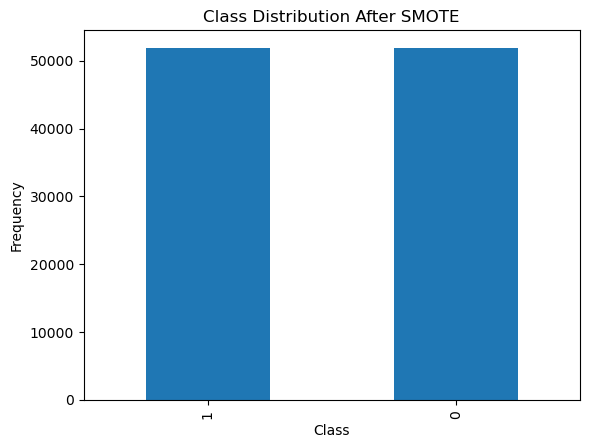

In [54]:
# Handling imbalanced data by applying resampling techniques like SMOTE
smote = SMOTE()
x_resampled, y_resampled = smote.fit_resample(x_data_selected, y_label_no_outliers)

# Convert y_resampled to a DataFrame for easier plotting
y_resampled_df = pd.DataFrame(y_resampled, columns=['type'])

# Check the distribution of the classes
class_distribution = y_resampled_df['type'].value_counts()
print(class_distribution)

# Plot the distribution of the classes
class_distribution.plot(kind='bar', title='Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

[learning_curve] Training set sizes: [ 8305 16610 24916 33221 41527 49832 58137 66443 74748 83054]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:  6.4min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 14.3min finished
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in w

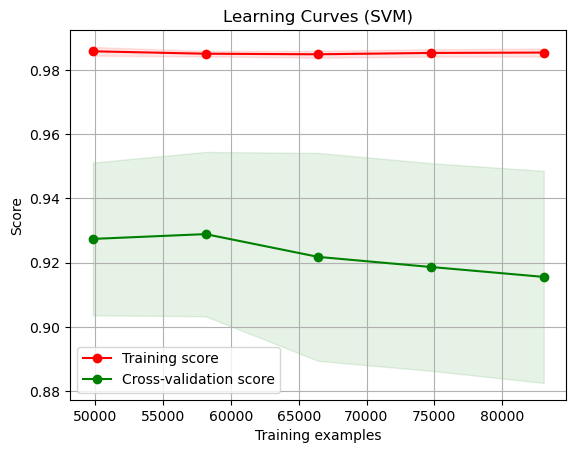

In [59]:
# Define the SVM model
svm_model = SVC(kernel='rbf', C=1, gamma='scale', decision_function_shape='ovr')

# Plot learning curves
train_sizes, train_scores, test_scores = learning_curve(
    svm_model, x_resampled, y_resampled, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy', verbose=2)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure()
plt.title("Learning Curves (SVM)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

# Plot the mean and standard deviation for training scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")

# Plot the mean and standard deviation for test scores
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

Selected Features: Index(['0_pre-RR', '0_rPeak', '0_sPeak', '0_qPeak', '0_qrs_interval',
       '0_st_interval', '0_qrs_morph1', '0_qrs_morph2', '0_qrs_morph3',
       '0_qrs_morph4'],
      dtype='object')
Training set shape: (144132, 10)
Testing set shape: (36034, 10)


SVM Model Training

In [70]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

print("Selected Features:", selected_features)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Selected Features: Index(['0_pre-RR', '0_post-RR', '0_pPeak', '0_tPeak', '0_rPeak', '0_sPeak',
       '0_qPeak', '1_tPeak', '1_rPeak', '1_sPeak'],
      dtype='object')
Training set shape: (83054, 10)
Testing set shape: (20764, 10)


In [ ]:
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# --- SVM Training and Tuning ---
# Define parameter distributions for random search
param_dist = {
    'C': uniform(0.1, 10),  # Continuous distribution for C
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': uniform(0.001, 1),  # For RBF kernel
    'degree': randint(2, 5),  # For polynomial kernel
    'decision_function_shape': ['ovr']  # Set to 'ovr' for binary classification
}

# Use a subset of data for tuning to improve efficiency
subset_size = min(2000, X_train.shape[0])  # Use 1000 samples
subset_idx = np.random.choice(X_train.shape[0], subset_size, replace=False)
X_train_subset = X_train[subset_idx]
y_train_subset = y_train[subset_idx]

Training samples: 83054, Test samples: 20764


In [96]:
# Perform random search
svm = SVC(probability=True)  # Enable probability for visualization
random_search = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=50, cv=5, 
                                   random_state=42, n_jobs=-1, verbose=2)
random_search.fit(X_train_subset, y_train_subset)

# Get the best parameters and train the final model
best_params = random_search.best_params_
print("Best parameters from random search:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from random search: {'C': 6.72522284353982, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.4261558744912447, 'kernel': 'rbf'}


In [97]:
# Assuming random_search is your RandomizedSearchCV object

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best parameters from random search:", best_params)
print("Best cross-validation score from random search:", best_score)

# Get detailed results for all parameter combinations
cv_results = random_search.cv_results_

# Convert cv_results to a DataFrame for easier inspection
cv_results_df = pd.DataFrame(cv_results)

# Sort the DataFrame by mean test score in descending order
cv_results_df = cv_results_df.sort_values(by='mean_test_score', ascending=False)

# Display the top 5 parameter combinations
print(cv_results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head())

Best parameters from random search: {'C': 6.72522284353982, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.4261558744912447, 'kernel': 'rbf'}
Best cross-validation score from random search: 0.9684999999999999
                                               params  mean_test_score  \
14  {'C': 6.72522284353982, 'decision_function_sha...           0.9685   
42  {'C': 5.287906217433661, 'decision_function_sh...           0.9675   
13  {'C': 0.44388521115218393, 'decision_function_...           0.9620   
46  {'C': 2.8864646423661147, 'decision_function_s...           0.9615   
28  {'C': 9.817120953891036, 'decision_function_sh...           0.9605   

    std_test_score  rank_test_score  
14        0.006442                1  
42        0.006124                2  
13        0.009798                3  
46        0.010440                4  
28        0.009670                5  


In [99]:
# Train the final model on the full balanced dataset
final_svm = SVC(**best_params, probability=True)
final_svm.fit(X_train, y_train)

# Predict on test set
y_pred = final_svm.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9964361394721634
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     10225
           1       1.00      0.99      1.00     10539

    accuracy                           1.00     20764
   macro avg       1.00      1.00      1.00     20764
weighted avg       1.00      1.00      1.00     20764

Confusion Matrix:
 [[10220     5]
 [   69 10470]]


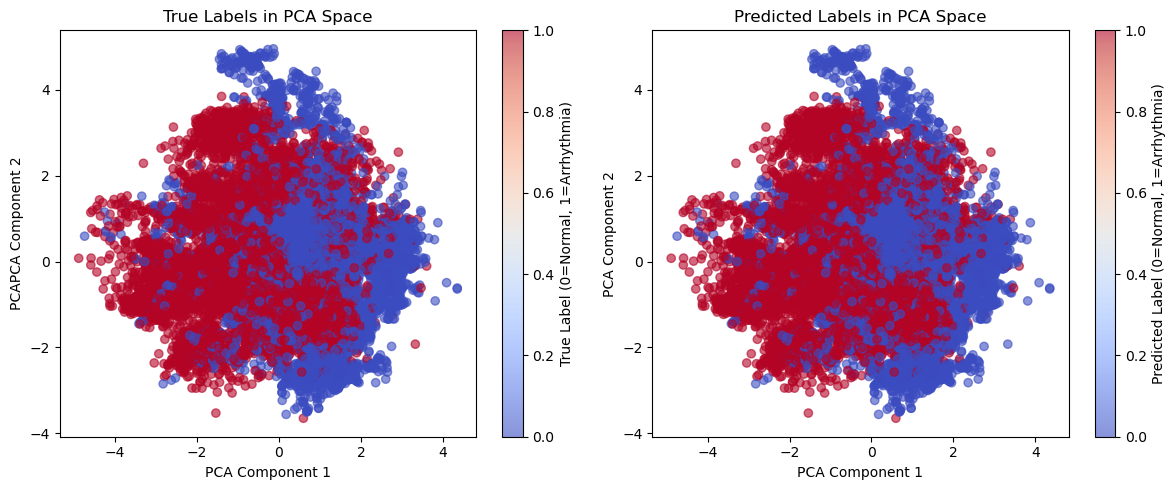

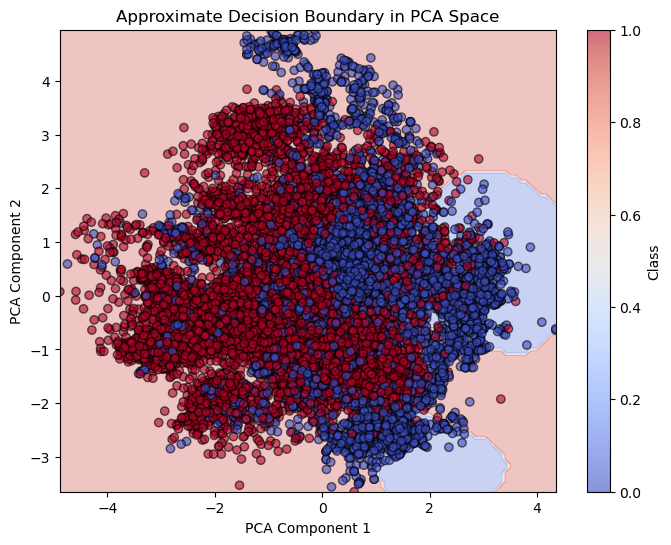

In [108]:
# --- Visualization in PCA Space ---
# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Predict probabilities for decision boundary
y_pred_proba = final_svm.predict_proba(X_test)[:, 1]

# Plotting true vs predicted labels in PCA space
plt.figure(figsize=(12, 5))

# Subplot 1: True labels
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter, label='True Label (0=Normal, 1=Arrhythmia)')
plt.title("True Labels in PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCAPCA Component 2")

# Subplot 2: Predicted labels
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter, label='Predicted Label (0=Normal, 1=Arrhythmia)')
plt.title("Predicted Labels in PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.tight_layout()
plt.show()

# Approximate decision boundary in PCA space
xx, yy = np.meshgrid(np.linspace(X_test_pca[:, 0].min(), X_test_pca[:, 0].max(), 100),
                     np.linspace(X_test_pca[:, 1].min(), X_test_pca[:, 1].max(), 100))
grid_pca = np.c_[xx.ravel(), yy.ravel()]

# Inverse transform to original space (approximation)
grid_original = pca.inverse_transform(grid_pca)
Z = final_svm.predict(grid_original)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', edgecolors='k', alpha=0.6)
plt.title("Approximate Decision Boundary in PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Class')
plt.show()

c:\Users\Admin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Admin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Admin\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

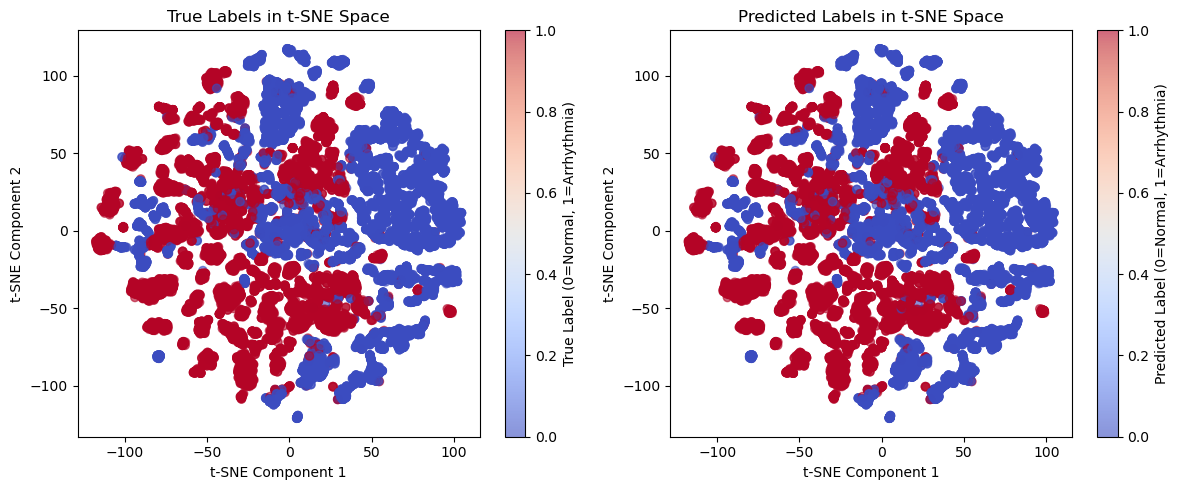

In [109]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(X_test)

# Plotting true vs predicted labels in t-SNE space
plt.figure(figsize=(12, 5))

# Subplot 1: True labels
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test, cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter, label='True Label (0=Normal, 1=Arrhythmia)')
plt.title("True Labels in t-SNE Space")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Subplot 2: Predicted labels
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_pred, cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter, label='Predicted Label (0=Normal, 1=Arrhythmia)')
plt.title("Predicted Labels in t-SNE Space")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.tight_layout()
plt.show()

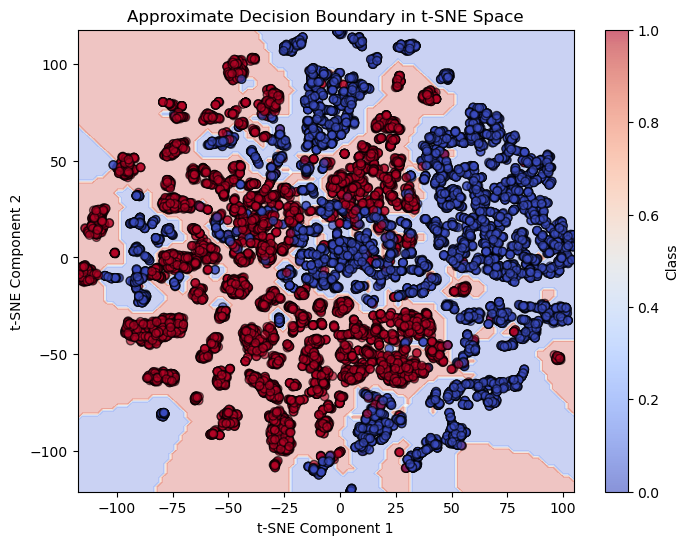

In [117]:
# Approximate decision boundary in t-SNE space
xx, yy = np.meshgrid(np.linspace(X_test_tsne[:, 0].min(), X_test_tsne[:, 0].max(), 100),
                     np.linspace(X_test_tsne[:, 1].min(), X_test_tsne[:, 1].max(), 100))
grid_tsne = np.c_[xx.ravel(), yy.ravel()]

# Use the nearest neighbors to approximate the decision boundary
from sklearn.neighbors import NearestNeighbors

# Fit nearest neighbors on the t-SNE transformed test data
nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_test_tsne)

# Find the nearest neighbors in the original space
distances, indices = nn.kneighbors(grid_tsne)
grid_original = X_test[indices.flatten()]

# Predict using the SVM model
Z = final_svm.predict(grid_original)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test, cmap='coolwarm', edgecolors='k', alpha=0.6)
plt.title("Approximate Decision Boundary in t-SNE Space")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label='Class')
plt.show()

In [111]:
! pip install umap

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3550 sha256=10817a257cbd44881ca04216c3e6e8b19a43d7ef8d9ef9d16decd183b6d2fa74
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\48\4a\1c\1d511cbb0413a448d8546e958f8e82b98d9bb493038d19ece2
Successfully built umap


c:\Users\Admin\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


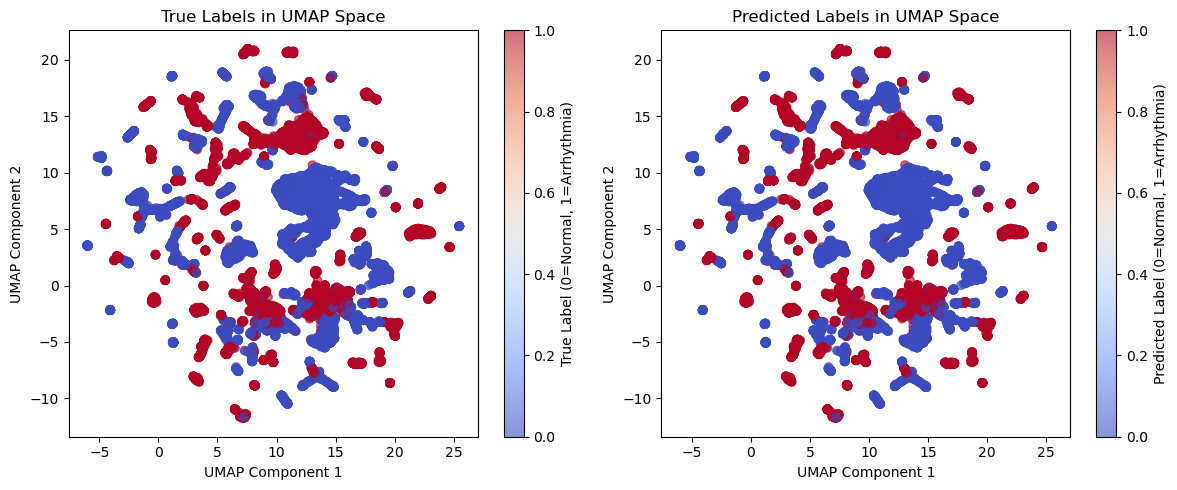

In [114]:
%pip install umap-learn

import umap.umap_ as umap

# Reduce dimensionality to 2D using UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_test_umap = umap_model.fit_transform(X_test)

# Plotting true vs predicted labels in UMAP space
plt.figure(figsize=(12, 5))

# Subplot 1: True labels
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_test, cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter, label='True Label (0=Normal, 1=Arrhythmia)')
plt.title("True Labels in UMAP Space")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

# Subplot 2: Predicted labels
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_pred, cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter, label='Predicted Label (0=Normal, 1=Arrhythmia)')
plt.title("Predicted Labels in UMAP Space")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

plt.tight_layout()
plt.show()

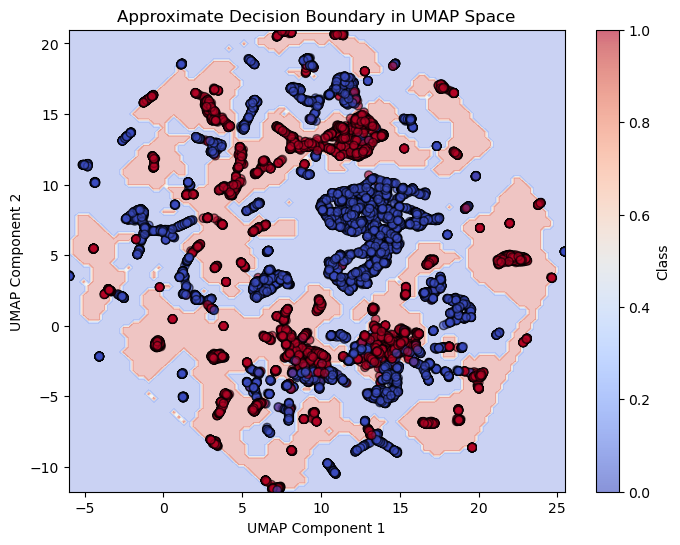

In [118]:
# Approximate decision boundary in UMAP space
xx, yy = np.meshgrid(np.linspace(X_test_umap[:, 0].min(), X_test_umap[:, 0].max(), 100),
                     np.linspace(X_test_umap[:, 1].min(), X_test_umap[:, 1].max(), 100))
grid_umap = np.c_[xx.ravel(), yy.ravel()]

# Inverse transform to original space (approximation)
grid_original = umap_model.inverse_transform(grid_umap)
Z = final_svm.predict(grid_original)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_test, cmap='coolwarm', edgecolors='k', alpha=0.6)
plt.title("Approximate Decision Boundary in UMAP Space")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.colorbar(label='Class')
plt.show()

Pairs of points with similar behaviors but different classes:
Point 116 (Class 1) and Point 1555 (Class 0)
Point 567 (Class 1) and Point 10215 (Class 0)
Point 623 (Class 1) and Point 5239 (Class 0)
Point 832 (Class 1) and Point 13894 (Class 0)
Point 1102 (Class 1) and Point 13844 (Class 0)
Point 1150 (Class 1) and Point 1126 (Class 0)
Point 1151 (Class 1) and Point 12395 (Class 0)
Point 1158 (Class 1) and Point 11594 (Class 0)
Point 1241 (Class 0) and Point 14373 (Class 1)
Point 1262 (Class 1) and Point 11372 (Class 0)
Point 1493 (Class 1) and Point 4736 (Class 0)
Point 1714 (Class 0) and Point 20430 (Class 1)
Point 1740 (Class 1) and Point 8224 (Class 0)
Point 2015 (Class 1) and Point 14114 (Class 0)
Point 2033 (Class 1) and Point 8229 (Class 0)
Point 2182 (Class 1) and Point 388 (Class 0)
Point 2403 (Class 1) and Point 1969 (Class 0)
Point 2458 (Class 1) and Point 7442 (Class 0)
Point 2469 (Class 1) and Point 5567 (Class 0)
Point 2575 (Class 1) and Point 9801 (Class 0)
Point 2686 (Cl

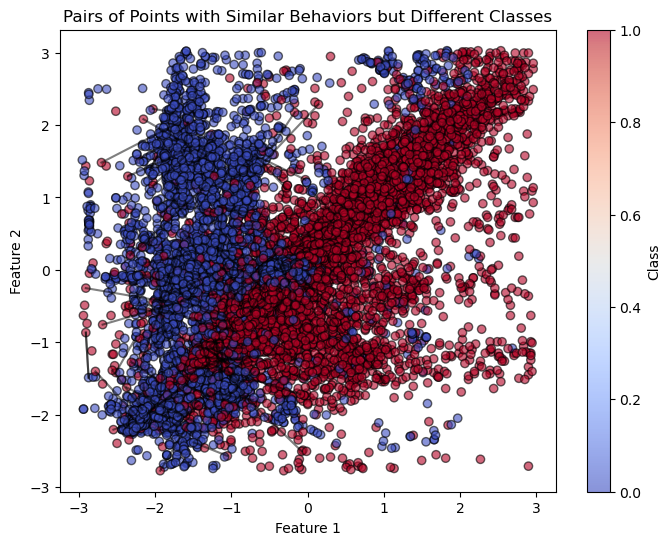

In [122]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Assuming X and y are your feature matrix and labels
X = X_test  # Use your dataset here
y = y_test  # Use your labels here

# Fit k-NN model
knn = NearestNeighbors(n_neighbors=2)
knn.fit(X)

# Find the nearest neighbors
distances, indices = knn.kneighbors(X)

# Identify pairs with different classes
pairs = []
for i in range(len(X)):
    if y[i] != y[indices[i][1]]:
        pairs.append((i, indices[i][1]))

# Print the pairs with different classes
print("Pairs of points with similar behaviors but different classes:")
for pair in pairs:
    print(f"Point {pair[0]} (Class {y[pair[0]]}) and Point {pair[1]} (Class {y[pair[1]]})")

# Visualize the pairs
plt.figure(figsize=(8, 6))
for pair in pairs:
    plt.plot([X[pair[0], 0], X[pair[1], 0]], [X[pair[0], 1], X[pair[1], 1]], 'k-', alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', alpha=0.6)
plt.title("Pairs of Points with Similar Behaviors but Different Classes")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Class')
plt.show()

In [125]:
indices

array([[    0, 12786],
       [    1, 12705],
       [    2,  5310],
       ...,
       [20761,  4444],
       [20762, 15455],
       [20763,  1584]], dtype=int64)

In [123]:
# Print the pairs with different classes and their data
print("Pairs of points with similar behaviors but different classes:")
for pair in pairs:
    print(f"Point {pair[0]} (Class {y[pair[0]]}): {X[pair[0]]}")
    print(f"Point {pair[1]} (Class {y[pair[1]]}): {X[pair[1]]}")
    print()

Pairs of points with similar behaviors but different classes:
Point 116 (Class 1): [-2.51428433 -1.4200594  -0.09550659 -0.01316001 -1.60850379  0.24342041
  0.89848311 -0.11614682 -0.55504271 -0.39107325]
Point 1555 (Class 0): [-2.24670426 -0.92644262  0.05880056  0.16195282 -1.32668436  0.36449342
  0.69449943  0.36327861  0.29051606  0.02228617]

Point 567 (Class 1): [-1.25591476  1.87565739  1.43951822 -0.45940974 -3.17436312 -0.68504203
 -2.0982079   1.11677527 -0.19019432  0.64451541]
Point 10215 (Class 0): [-1.48801762  1.3864131   1.14920672 -0.06751936 -3.1436541  -0.67209196
 -1.92984427  0.05278349 -0.50992378 -0.35595939]

Point 623 (Class 1): [ 0.09683253 -0.28469285  0.88886753  0.32445775 -0.97769184  0.51442478
  1.47116191 -0.11595852 -0.59247009 -0.42052215]
Point 5239 (Class 0): [-0.07275028 -0.13069826  0.54365815  0.29259028 -1.05380171  0.48172707
  1.57474833  0.09690966  0.09040101  0.03064937]

Point 832 (Class 1): [-1.57050715 -1.54621123 -1.53436088  0.812132

The SVM model can predict well even when there are pairs of points with similar behaviors but different classes because of its ability to find an optimal hyperplane that maximizes the margin between different classes. Here are some reasons why SVM can handle such cases effectively:

- Margin Maximization: SVM aims to find the hyperplane that maximizes the margin between the classes. This helps in achieving better generalization and robustness to noise.

- Support Vectors: SVM relies on support vectors, which are the data points closest to the decision boundary. These support vectors help define the optimal hyperplane, making the model less sensitive to other points that are farther away from the boundary.

- Kernel Trick: SVM can use different kernel functions (e.g., linear, polynomial, RBF) to transform the data into a higher-dimensional space where it becomes easier to separate the classes. This allows SVM to handle complex, non-linear decision boundaries.

- Regularization: The C parameter in SVM controls the trade-off between achieving a low training error and a low testing error. A well-tuned C parameter helps the model to generalize better and avoid overfitting.